In [15]:
import cv2
import numpy as np
import imutils

video='kapildev.mp4'

# Create a VideoCapture object and read from input file
# If the input is the camera, pass 0 instead of the video file name
cap = cv2.VideoCapture(video)
cnt=0

# Check if camera opened successfully
if (cap.isOpened()== False): 
  print("Error opening video stream or file")

ret,first_frame = cap.read()

# Read until video is completed
while(cap.isOpened()):
    ret, frame = cap.read()     
    if ret == True:
        print(frame.shape)
        roi = frame[0:frame.shape[0]-0,:]
        thresh=60
        end = roi.shape[1] - thresh
        roi = roi[:,thresh:end]
        cv2.imwrite('frames/'+str(cnt)+'.png',roi)
        cnt=cnt+1
    else: 
        break

cv2.destroyAllWindows()

(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 

(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 568, 3)
(320, 

In [16]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
import re

#listing down all the file names
frames = os.listdir('frames/')
frames.sort(key=lambda f: int(re.sub('\D', '', f)))

#reading frames
images=[]
for i in frames:
    img = cv2.imread('frames/'+i)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.GaussianBlur(img,(3,3),0)
    images.append(img)

images=np.array(images)

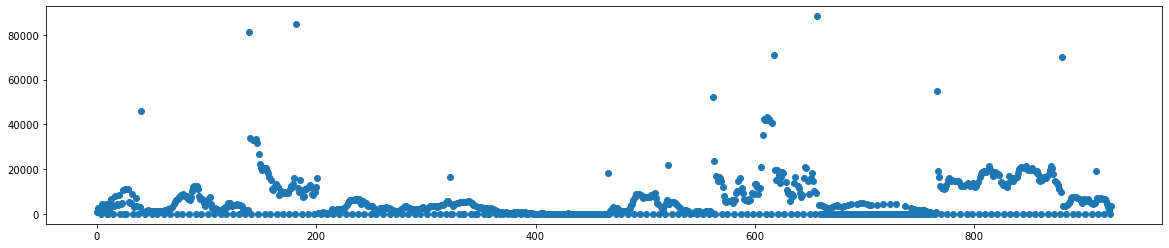

In [17]:
nonzero=[]
for i in range((len(images)-1)):
    
    mask = cv2.absdiff(images[i],images[i+1])
    _ , mask = cv2.threshold(mask, 50, 255, cv2.THRESH_BINARY)
    num = np.count_nonzero((mask.ravel()))
    nonzero.append(num)
    
    
x = np.arange(0,len(images)-1)
y = nonzero

plt.figure(figsize=(20,4))
plt.scatter(x,y)

In [18]:
threshold = 30000
for i in range(len(images)-1):
    if(nonzero[i]>threshold): 
        scene_change_idx = i
        break
        
frames = frames[:(scene_change_idx+1)]

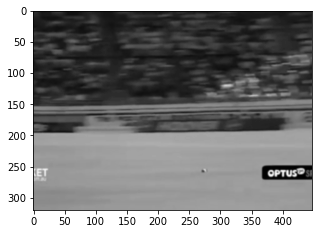

In [19]:
img= cv2.imread('frames/' + frames[10])
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray,(3,3),0)

plt.figure(figsize=(5,10))
plt.imshow(gray,cmap='gray')

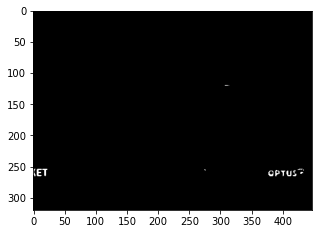

In [20]:
_ , mask = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)

plt.figure(figsize=(5,5))
plt.imshow(mask,cmap='gray')

In [21]:
contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

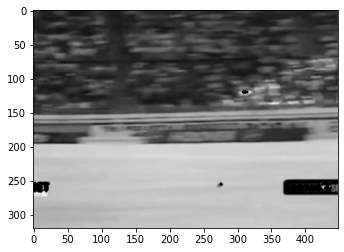

In [22]:
img_copy = np.copy(gray)
cv2.drawContours(img_copy, contours, -1, (0,255,0), 3)
plt.imshow(img_copy, cmap='gray')

In [23]:
num=20
cnt=0
for i in range(len(contours)):
    x,y,w,h = cv2.boundingRect(contours[i])
    
    numer=min([w,h])
    denom=max([w,h])
    ratio=numer/denom

    if(x>=num and y>=num):
        xmin, ymin= x-num, y-num
        xmax, ymax= x+w+num, y+h+num
    else:
        xmin, ymin=x, y
        xmax, ymax=x+w, y+h

    if(ratio>=0.1 and ((w<=10) and (h<=10)) ):    
        print(cnt,x,y,w,h,ratio)
        cv2.imwrite("patch/"+str(cnt)+".png",img[ymin:ymax,xmin:xmax])
        cnt=cnt+1

0 429 259 5 3 0.6
1 407 257 8 9 0.8888888888888888
2 398 257 7 9 0.7777777777777778
3 378 257 8 9 0.8888888888888888
4 379 257 7 7 1.0
5 417 256 6 10 0.6
6 389 256 7 10 0.7
7 390 257 5 5 1.0
8 434 255 1 2 0.5
9 275 255 2 2 1.0
10 425 254 8 2 0.25
11 314 120 1 1 1.0
12 308 120 5 1 0.2


In [24]:
import os
import cv2
import numpy as np
import pandas as pd
folders=os.listdir('data/')

images=[]
labels= []
for folder in folders:
    files=os.listdir('data/'+folder)
    for file in files:
        img=cv2.imread('data/'+folder+'/'+file,0)
        img=cv2.resize(img,(25,25))
        
        images.append(img)
        labels.append(int(folder))

images = np.array(images)
features = images.reshape(len(images),-1)

In [25]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val = train_test_split(features,labels, test_size=0.3, stratify=labels,random_state=0)

In [26]:
from sklearn.ensemble import RandomForestClassifier 
rfc = RandomForestClassifier(max_depth=10) 
rfc.fit(x_tr,y_tr)

RandomForestClassifier(max_depth=10)

In [27]:
from sklearn.metrics import classification_report
y_pred = rfc.predict(x_val)
print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.79      0.94      0.86        16
           1       0.94      0.79      0.86        19

    accuracy                           0.86        35
   macro avg       0.86      0.86      0.86        35
weighted avg       0.87      0.86      0.86        35



In [28]:
ball_df = pd.DataFrame(columns=['frame','x','y','w','h'])

for idx in range(len(frames)):
    
    img= cv2.imread('frames/' + frames[idx])
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray,(25, 25),0)
    _ , mask = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    num=20
    cnt=0
    df = pd.DataFrame(columns=['frame','x','y','w','h'])
    for i in range(len(contours)):
        x,y,w,h = cv2.boundingRect(contours[i])

        numer=min([w,h])
        denom=max([w,h])
        ratio=numer/denom

        if(x>=num and y>=num):
            xmin, ymin= x-num, y-num
            xmax, ymax= x+w+num, y+h+num
        else:
            xmin, ymin= x,y
            xmax, ymax= x+w, y+h

        if(ratio>=0.5):    
            #print(cnt,x,y,w,h,ratio)
            df.loc[cnt,'frame'] = frames[idx]
            df.loc[cnt,'x']=x
            df.loc[cnt,'y']=y
            df.loc[cnt,'w']=w
            df.loc[cnt,'h']=h
            
            cv2.imwrite("patch/"+str(cnt)+".png",img[ymin:ymax,xmin:xmax])
            cnt=cnt+1
    
    
    files=os.listdir('patch/')    
    if(len(files)>0):
    
        files.sort(key=lambda f: int(re.sub('\D', '', f)))

        test=[]
        for file in files:
            img=cv2.imread('patch/'+file,0)
            img=cv2.resize(img,(25,25))
            test.append(img)

        test = np.array(test)

        test = test.reshape(len(test),-1)
        y_pred = rfc.predict(test)
        prob=rfc.predict_proba(test)

        if 0 in y_pred:
            ind = np.where(y_pred==0)[0]
            proba = prob[:,0]
            confidence = proba[ind]
            confidence = [i for i in confidence if i>0.0]
            if(len(confidence)>0):

                maximum = max(confidence)
                ball_file=files[list(proba).index(maximum)]

                img= cv2.imread('patch/'+ball_file)
                cv2.imwrite('ball/'+str(frames[idx]),img)

                no = int(ball_file.split(".")[0])
                ball_df.loc[idx]= df.loc[no]
            else:
                ball_df.loc[idx,'frame']=frames[idx]

        else:
            ball_df.loc[idx,'frame']=frames[idx]

In [29]:
ball_df.dropna(inplace=True)
print(ball_df)

Empty DataFrame
Columns: [frame, x, y, w, h]
Index: []


In [ ]:
files = ball_df['frame'].values

num=10
for idx in range(len(files)):
    
    #draw contours 
    img = cv2.imread('frames/'+files[idx])
    
    x=ball_df.loc[idx+76,'x']
    y=ball_df.loc[idx+76,'y']
    w=ball_df.loc[idx+76,'w']
    h=ball_df.loc[idx+76,'h']
    
    xmin=x-num
    ymin=y-num
    xmax=x+w+num
    ymax=y+h+num

    cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255,0,0), 2)
    cv2.imwrite("frames/"+files[idx],img)

In [ ]:
frames = os.listdir('frames/')
frames.sort(key=lambda f: int(re.sub('\D', '', f)))

frame_array=[]

for i in range(len(frames)):
    #reading each files
    img = cv2.imread('frames/'+frames[i])
    height, width, layers = img.shape
    size = (width,height)
    #inserting the frames into an image array
    frame_array.append(img)

out = cv2.VideoWriter('kapildev_processed.mp4',cv2.VideoWriter_fourcc(*'MPEG'), 20, size)
 
for i in range(len(frame_array)):
    # writing to a image array
    out.write(frame_array[i])
out.release()